In [973]:
import numpy as np 
import itertools
import matplotlib.pyplot as plt
import pickle
import sys


In [974]:

#FUNCTION
def partition_N(n):
    '''do the partition of a complete graph'''
    indexs = range(n)
    pairs_all = []

    swap_even = [i + pow(-1, i) for i in range(n)]

    swap_odd = [0]
    swap_odd.extend([i + pow(-1, i+1) for i in range(1,n-1)])
    swap_odd.append(n-1)

    pairs_even = [(i, i+1) for i in range(0, n, 2)]
    indexs = np.array(indexs)[swap_even]   ### indexs after swap even
    #     print('\nindexs after swap {}: {}'.format(0, indexs))
    pairs_all.append(pairs_even)
    for i in range(1, n):
        if (i%2)==1:
            pair_odd = [(indexs[i], indexs[i+1]) for i in range(1, n-1, 2)]
            pairs_all.append(pair_odd)
            indexs = np.array(indexs)[swap_odd]   ### indexs after swap even
    #             print('\nindexs after swap {}: {}'.format(i, indexs))

        elif (i%2)==0:
            pair_even = [(indexs[i], indexs[i+1]) for i in range(0, n-1, 2)]
            pairs_all.append(pair_even)
            indexs = np.array(indexs)[swap_even]   ### indexs after swap even
    #             print('\nindexs after swap {}: {}'.format(i, indexs))

    return pairs_all



In [975]:
def compute_cvar(probabilities, values, alpha):
    """
    Auxilliary method to compute the conditional value at risk.

    Args:
        probabilities (List[Real]): The probabilities for measuring a bit string
        values (List[Real]): The corresponding energy values
        alpha (Real): Confidence level for the conditional value at risk

    Returns:
        cvar (Real): The conditional value at risk
    """
    
    sorted_indices = np.argsort(values)
    probs = np.array(probabilities)[sorted_indices]
    vals = np.array(values)[sorted_indices]

    cvar = 0
    total_prob = 0
    for i, (p, v) in enumerate(zip(probs, vals)):
        if p >= alpha - total_prob:
            p = alpha - total_prob
        total_prob += p
        cvar += p * v
        if abs(total_prob - alpha) < 1e-8:
            break

    cvar /= total_prob

    return cvar

In [976]:
num_variables_list = [str(num).zfill(3) for num in range(6,22, 2)]

N_ins = 100 ###100 50 number of random instances

ansatz_type = 'structure_like_qubo_YZ_2' 

layer = 1

shots = None

alpha = 0.01

achange = 10

tau =0.6

howmany = 1
 
dir_0 = './data_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

cvar_dict_all = []
solution_dict_all = []
best_energy_all = []

for num_variables in num_variables_list:

    # Initialize the dictionary using dictionary comprehension
    cvar_dict = {
    'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
    'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

    solution_dict = {
    'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
    'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

    solution_dict['old']['Random'] = []
    solution_dict['lightcone']['Random'] = []
    cvar_dict['old']['Random'] = []
    cvar_dict['lightcone']['Random'] = []

    best_energy = [] 

    n_qubits = int(num_variables)

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for initialization in ['warm_start_measure']:   #'warm_start_measure_lightcone'

        print('initialization', initialization, num_variables) 
        y = []

        dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                            .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in range(N_ins):
                
            file_dir_name = dir_name + '/r_{}'\
                            .format(r)
            
            #ADD THE RANDOM OPTION
            if initialization ==  'warm_start_measure':
                file_path = file_dir_name + '/tau_{}_random.pkl'\
                                                    .format(tau)
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)  

                probs = list(data['layers_exp_poss_dict']['l_1'].values())
                energies = list(data['layers_exp_poss_dict']['l_1'].keys())

                best_energy.append(energies[0])
                cvar = compute_cvar(probs, energies, alpha*achange)
                cvar_dict['old']['Random'].append(cvar)

                print(energies)
                print(best_energy)
                print(cvar)

                fidelity = 0
                for item in range(howmany):            
                    fidelity += list(data['layers_exp_poss_dict']['l_1'].items())[item][1]     
                solution_dict['old']['Random'].append(fidelity)

            # elif initialization == 'warm_start_measure_lightcone':   #MODIFY
            #     file_path_lightcone = file_dir_name + '/tau_{}_random.pkl'\
            #                                         .format(tau)
            #     with open(file_path_lightcone, 'rb') as f:
            #         data_lightcone = pickle.load(f)            
            #     fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
            #     solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(fidelity)
            #     overlap = data['ite_overlap']
            #     iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(overlap)

            else:
                sys.stderr.write('something is wrong with initialization')
                sys.exit()

            #ADD ALL THE SORTING OPTIONS
            for Abs in [True, False]:
                for invert in [True, False]:

                    if initialization ==  'warm_start_measure':
                        file_path = file_dir_name + '/tau_{}_{}_{}.pkl'\
                                                    .format(tau, Abs, invert)
                        with open(file_path, 'rb') as f:
                            data = pickle.load(f)

                        probs = list(data['layers_exp_poss_dict']['l_1'].values())
                        energies = list(data['layers_exp_poss_dict']['l_1'].keys())
                        cvar = compute_cvar(probs, energies, alpha*achange)
                        cvar_dict['old'][f'Sort_{Abs}_{invert}'].append(cvar)

                        fidelity = 0 
                        for item in range(howmany):            
                            fidelity += list(data['layers_exp_poss_dict']['l_1'].items())[item][1]
                        solution_dict['old'][f'Sort_{Abs}_{invert}'].append(fidelity)

                    # elif initialization == 'warm_start_measure_lightcone':   #MODIFY
                    #     file_path_lightcone = file_dir_name + '/tau_{}_{}_{}.pkl'\
                    #                                         .format(tau, Abs, invert)
                    #     with open(file_path_lightcone, 'rb') as f:
                    #         # Load the content of the file using pickle.load()
                    #         data_lightcone = pickle.load(f)            
                    #     fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
                    #     solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(fidelity)
                    #     overlap = data['ite_overlap']
                    #     iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(overlap)

                    else:
                        sys.stderr.write('something is wrong with initialization')
                        sys.exit()

    cvar_dict_all.append(cvar_dict)
    solution_dict_all.append(solution_dict)
    best_energy_all.append(best_energy)
    
print(best_energy_all)

initialization warm_start_measure 006
[-6.1137, -5.800099999999999, -5.1509, -4.513099999999999, -3.873699999999999, -3.7927000000000004, -3.2340999999999993, -3.0181, -2.8961, -2.8093, -2.5551, -2.5505, -2.5325, -2.3767, -1.8094999999999999, -1.8081, -1.5888999999999989, -1.5588999999999995, -1.4739000000000004, -1.4567000000000005, -1.3575, -1.2681000000000007, -1.2164999999999995, -1.1989, -1.1011000000000002, -1.0327000000000002, -0.8689000000000001, -0.5031000000000001, -0.4472999999999997, -0.2976999999999994, -0.2915000000000002, -0.13970000000000005, -0.0029000000000000137, 0.13849999999999985, 0.8110999999999998, 0.8119000000000002, 0.8472999999999998, 0.8644999999999999, 0.8725000000000002, 0.9799000000000001, 1.0397000000000003, 1.2261000000000002, 1.4649000000000005, 1.547699999999999, 1.7451000000000003, 2.0363, 2.0579000000000005, 2.2085000000000004, 2.2736999999999994, 2.3619000000000008, 2.3777000000000004, 2.4453, 2.4613, 2.6169, 2.7097, 2.9028999999999994, 2.950300000

006 KEYS ['Random', 'Random', 'Random', 'Sort_True_True', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Sort_True_True', 'Random', 'Sort_True_False', 'Random', 'Random', 'Random', 'Random', 'Sort_True_True', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Sort_False_True', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random'

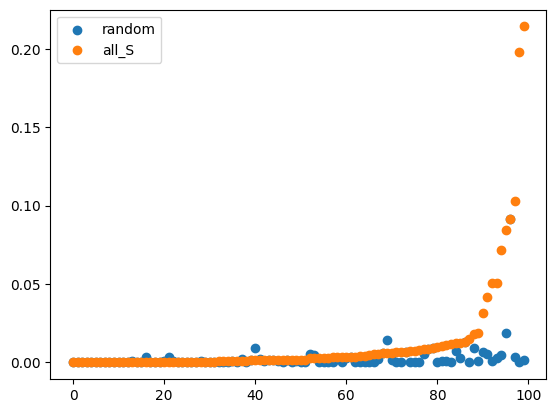

In [977]:
best_sorted_all_cvar = []
best_sorted_all_cvarfidelity = []

for j,num_variables in enumerate(num_variables_list):

    keys = [] 
    for i in range(N_ins):
        current_value = cvar_dict_all[j]['old']['Random'][i]
        new_key = 'Random'

        for Abs in [True, False]:
            for invert in [True, False]: 
                if cvar_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i] < current_value:
                    current_value = cvar_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i]
                    new_key = f'Sort_{Abs}_{invert}'
        keys.append(new_key)

    print(num_variables, 'KEYS', keys)

    best_sorted_cvar = [ cvar_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]
    best_sorted_cvarfidelity = [ solution_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]

    best_sorted_all_cvar.append(best_sorted_cvar)
    best_sorted_all_cvarfidelity.append(best_sorted_cvarfidelity)

# sorted_ind = np.argsort(solution_dict['old']['Random'])
sorted_ind = np.argsort(best_sorted_cvar)
# plt.scatter(range(N_ins), np.array(cvar_dict['old']['Random'])[sorted_ind], label = 'random')
# plt.scatter(range(N_ins), np.array(best_sorted_cvar)[sorted_ind], label = 'all_S')
# plt.legend()

sorted_ind = np.argsort(best_sorted_cvarfidelity)
plt.scatter(range(N_ins), np.array(solution_dict['old']['Random'])[sorted_ind], label = 'random')
plt.scatter(range(N_ins), np.array(best_sorted_cvarfidelity)[sorted_ind], label = 'all_S')
plt.legend()

In [978]:
#CHEATING SORTING

######################################################
#Try to sort adaptively CHEATING - old style 

best_sorted_all_cheat = []

for j,num_variables in enumerate(num_variables_list):

    keys = [] 
    for i in range(N_ins):
        current_value = solution_dict_all[j]['old']['Random'][i]
        new_key = 'Random'

        for Abs in [True, False]:
            for invert in [True, False]: 
                if solution_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i] > current_value:
                    current_value = solution_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i]
                    new_key = f'Sort_{Abs}_{invert}'
        keys.append(new_key)

    best_sorted_cheat = [ solution_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]

    best_sorted_all_cheat.append(best_sorted_cheat)


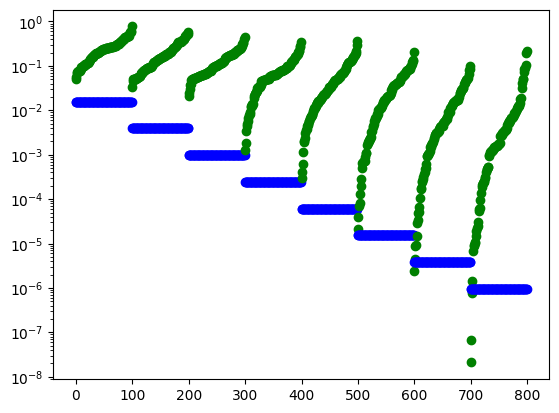

In [979]:
for j,num_variables in enumerate(num_variables_list):
    n_qubits = int(num_variables)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    #plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    # plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

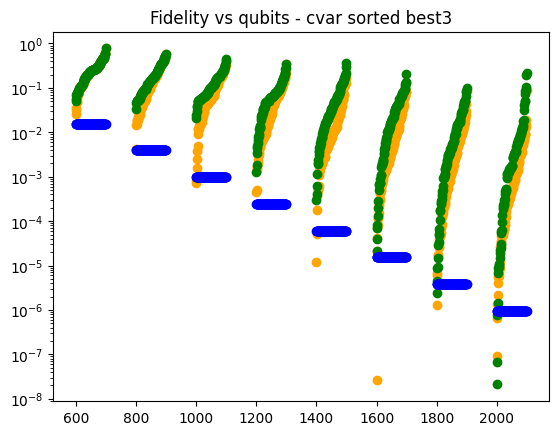

In [980]:
for j,num_variables in enumerate(num_variables_list):
    n_qubits = int(num_variables)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x +100*(n_qubits), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    plt.scatter(x+100*(n_qubits), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    # plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+100*(n_qubits), y4, label = 'random', color='blue')
    plt.yscale('log')
    plt.title("Fidelity vs qubits - cvar sorted best3")
    # plt.legend()

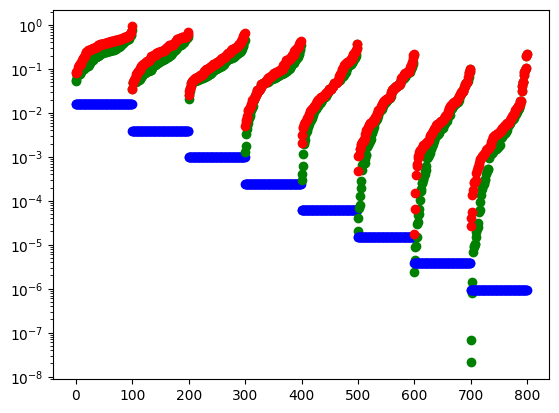

In [981]:
for j,num_variables in enumerate(num_variables_list):
    n_qubits = int(num_variables)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    #plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

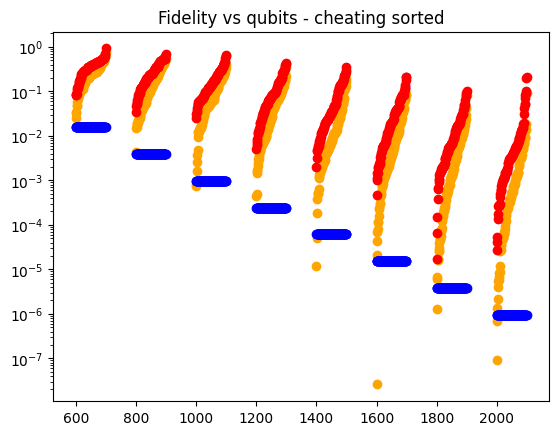

In [982]:
for j,num_variables in enumerate(num_variables_list):
    n_qubits = int(num_variables)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    #plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    plt.scatter(x+100*(n_qubits), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    plt.scatter(x+100*(n_qubits), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+100*(n_qubits), y4, label = 'random', color='blue')
    plt.yscale('log')
    plt.title("Fidelity vs qubits - cheating sorted")
    # plt.legend()


tau =  6 alpha =  0.01
-6.1137 -6.1137
-5.544499999999998 -5.544499999999998
-5.185099999999999 -5.1850999999999985
-4.6021 -4.6021
-5.811800000000001 -5.811800000000001
-5.065999999999999 -5.065999999999999
-5.2654000000000005 -5.2654000000000005
-6.146799999999999 -6.146799999999999
-7.1343000000000005 -7.1343000000000005
-7.6413 -7.6413
-6.2364 -6.2364
-5.7102 -5.7102
-5.705299999999999 -5.705299999999999
-7.176200000000001 -7.1762000000000015
-5.570600000000001 -5.570600000000001
-11.065299999999997 -11.065299999999997
-5.486899999999999 -5.486899999999999
-7.1358999999999995 -7.1358999999999995
-6.309199999999999 -6.309199999999999
-5.251799999999999 -5.251799999999999
-5.499 -5.498999999999999
-4.416200000000001 -4.416200000000001
-6.203 -6.203
-5.410699999999999 -5.410699999999999
-5.237499999999998 -5.237499999999998
-5.6325 -5.6325
-6.6722 -6.6722
-5.623799999999999 -5.623799999999999
-6.749700000000001 -6.749700000000001
-4.627999999999998 -4.627999999999998
-5.2144999999999

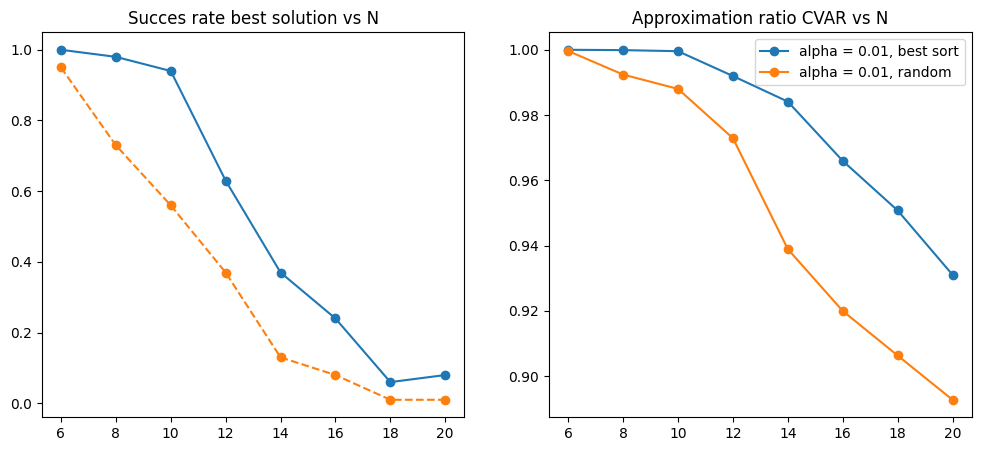

In [983]:
r_list = range(100)
tau_list = [6,8,10,12,14,16,18,20]
alpha_list = [0.01]

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
for alpha in alpha_list:
    sr_array = np.zeros((len(num_opt_list), len(tau_list)))
    ar_array = np.zeros(len(tau_list))
    rand_ar_array  = np.zeros(len(tau_list))
    for taui, tau in enumerate(tau_list):
        print("\ntau = ", tau, "alpha = ", alpha)
        # fidelities = np.sort(best_sorted_all_cvarfidelity[taui])[::-1]
        fidelities = best_sorted_all_cvarfidelity[taui]
        cvars = best_sorted_all_cvar[taui]

        rand_fidelity = solution_dict_all[taui]['old']['Random']
        rand_cvars = cvar_dict_all[taui]['old']['Random']

        best_energies = best_energy_all[taui]
        for r in r_list:
            if fidelities[r] > alpha*achange:
                sr_array[0, taui] += 1/len(r_list)
            if rand_fidelity[r] > alpha*achange:
                sr_array[1, taui] += 1/len(r_list)

            exp_opt = best_energies[r]
            ar_array[taui] += (cvars[r]/exp_opt) / len(r_list)

            rand_ar_array[taui] += (rand_cvars[r]/exp_opt) / len(r_list)
            print(exp_opt, cvars[r])

            

    print("sr_array = ", sr_array)
    ax1.plot(tau_list, sr_array[0], "o-", label=f"alpha = {alpha}, best sort")
    ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, random")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tau_list, ar_array, "o-", label=f"alpha = {alpha}, best sort")
    ax2.plot(tau_list, rand_ar_array, "o-", label=f"alpha = {alpha}, random")
    print("ar_array = ", ar_array)

    ax1.set_title('Succes rate best solution vs N')
    ax2.set_title('Approximation ratio CVAR vs N')
plt.legend()


TRY N=20 CMOPARE TAU

In [984]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)]

N_ins = 100 ###100 50 number of random instances

ansatz_type = 'structure_like_qubo_YZ_2' 

layer = 1

shots = None

alpha = 0.01

tau_list = [0.3, 0.4, 0.6, 0.8, 1.0] 

dir_0 = './data_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

cvar_dict_all = []
solution_dict_all = []
best_energy_all = []

for tau in tau_list:

    for num_variables in num_variables_list:

        # Initialize the dictionary using dictionary comprehension
        cvar_dict = {
        'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
        'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

        solution_dict = {
        'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
        'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

        solution_dict['old']['Random'] = []
        solution_dict['lightcone']['Random'] = []
        cvar_dict['old']['Random'] = []
        cvar_dict['lightcone']['Random'] = []

        best_energy = []

        n_qubits = int(num_variables)

        pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
        num_pairs = len(pairs_all)
        num_params = (n_qubits + 2*num_pairs) * layer

        for initialization in ['warm_start_measure']:   #'warm_start_measure_lightcone'

            print('initialization', initialization, num_variables, tau) 
            y = []

            dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                                .format(num_variables, num_params, layer, alpha, initialization)
            
            for r in range(N_ins):
                    
                file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                
                #ADD THE RANDOM OPTION
                if initialization ==  'warm_start_measure':
                    file_path = file_dir_name + '/tau_{}_random.pkl'\
                                                        .format(tau)
                    with open(file_path, 'rb') as f:
                        data = pickle.load(f)  

                    probs = list(data['layers_exp_poss_dict']['l_1'].values())
                    energies = list(data['layers_exp_poss_dict']['l_1'].keys())
                    cvar = compute_cvar(probs, energies, alpha*achange)
                    cvar_dict['old']['Random'].append(cvar)

                    best_energy.append(energies[0])

                    fidelity = 0
                    for item in range(howmany):            
                        fidelity += list(data['layers_exp_poss_dict']['l_1'].items())[item][1]     
                    solution_dict['old']['Random'].append(fidelity)

                # elif initialization == 'warm_start_measure_lightcone':   #MODIFY
                #     file_path_lightcone = file_dir_name + '/tau_{}_random.pkl'\
                #                                         .format(tau)
                #     with open(file_path_lightcone, 'rb') as f:
                #         data_lightcone = pickle.load(f)            
                #     fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
                #     solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(fidelity)
                #     overlap = data['ite_overlap']
                #     iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(overlap)

                else:
                    sys.stderr.write('something is wrong with initialization')
                    sys.exit()

                #ADD ALL THE SORTING OPTIONS
                for Abs in [True, False]:
                    for invert in [True, False]:

                        if initialization ==  'warm_start_measure':
                            file_path = file_dir_name + '/tau_{}_{}_{}.pkl'\
                                                        .format(tau, Abs, invert)
                            with open(file_path, 'rb') as f:
                                data = pickle.load(f)

                            probs = list(data['layers_exp_poss_dict']['l_1'].values())
                            energies = list(data['layers_exp_poss_dict']['l_1'].keys())
                            cvar = compute_cvar(probs, energies, alpha*achange)
                            cvar_dict['old'][f'Sort_{Abs}_{invert}'].append(cvar)

                            fidelity = 0 
                            for item in range(howmany):            
                                fidelity += list(data['layers_exp_poss_dict']['l_1'].items())[item][1]
                            solution_dict['old'][f'Sort_{Abs}_{invert}'].append(fidelity)

                        # elif initialization == 'warm_start_measure_lightcone':   #MODIFY
                        #     file_path_lightcone = file_dir_name + '/tau_{}_{}_{}.pkl'\
                        #                                         .format(tau, Abs, invert)
                        #     with open(file_path_lightcone, 'rb') as f:
                        #         # Load the content of the file using pickle.load()
                        #         data_lightcone = pickle.load(f)            
                        #     fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
                        #     solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(fidelity)
                        #     overlap = data['ite_overlap']
                        #     iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(overlap)

                        else:
                            sys.stderr.write('something is wrong with initialization')
                            sys.exit()

    cvar_dict_all.append(cvar_dict)
    solution_dict_all.append(solution_dict)
    best_energy_all.append(best_energy)

initialization warm_start_measure 020 0.3
initialization warm_start_measure 020 0.4
initialization warm_start_measure 020 0.6
initialization warm_start_measure 020 0.8
initialization warm_start_measure 020 1.0


In [985]:
print(len(cvar_dict_all))

5


0.3 KEYS ['Sort_True_True', 'Sort_True_True', 'Sort_False_False', 'Sort_False_True', 'Sort_True_True', 'Sort_True_True', 'Random', 'Sort_True_False', 'Sort_False_True', 'Sort_True_True', 'Sort_True_True', 'Sort_True_True', 'Sort_True_False', 'Sort_False_True', 'Sort_False_True', 'Sort_False_True', 'Random', 'Sort_False_True', 'Random', 'Sort_False_True', 'Sort_True_True', 'Sort_True_False', 'Sort_False_True', 'Sort_True_True', 'Sort_True_False', 'Sort_False_True', 'Sort_False_False', 'Sort_True_False', 'Sort_False_True', 'Random', 'Sort_True_True', 'Sort_True_True', 'Sort_False_True', 'Sort_False_True', 'Sort_False_False', 'Sort_False_False', 'Sort_True_True', 'Sort_False_False', 'Sort_True_False', 'Random', 'Sort_False_False', 'Sort_False_False', 'Random', 'Sort_True_True', 'Sort_True_True', 'Sort_False_False', 'Sort_True_False', 'Sort_False_True', 'Sort_False_True', 'Sort_True_True', 'Sort_True_False', 'Sort_False_False', 'Sort_False_False', 'Sort_False_True', 'Sort_True_True', 'Sort

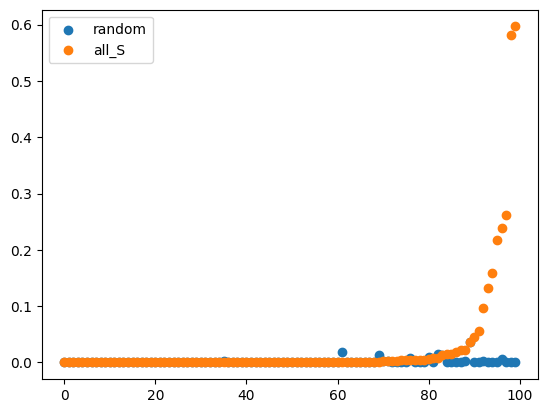

In [986]:
best_sorted_all_cvar = []
best_sorted_all_cvarfidelity = []

num_variables = 20

for j,tau in enumerate(tau_list):

    keys = [] 
    for i in range(N_ins):
        current_value = cvar_dict_all[j]['old']['Random'][i]
        new_key = 'Random'

        for Abs in [True, False]:
            for invert in [True, False]: 
                if cvar_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i] < current_value:
                    current_value = cvar_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i]
                    new_key = f'Sort_{Abs}_{invert}'
        keys.append(new_key)

    print(tau, 'KEYS', keys)

    best_sorted_cvar = [ cvar_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]
    best_sorted_cvarfidelity = [ solution_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]

    best_sorted_all_cvar.append(best_sorted_cvar)
    best_sorted_all_cvarfidelity.append(best_sorted_cvarfidelity)

# sorted_ind = np.argsort(solution_dict['old']['Random'])
sorted_ind = np.argsort(best_sorted_cvar)
# plt.scatter(range(N_ins), np.array(cvar_dict['old']['Random'])[sorted_ind], label = 'random')
# plt.scatter(range(N_ins), np.array(best_sorted_cvar)[sorted_ind], label = 'all_S')
# plt.legend()

sorted_ind = np.argsort(best_sorted_cvarfidelity)
plt.scatter(range(N_ins), np.array(solution_dict['old']['Random'])[sorted_ind], label = 'random')
plt.scatter(range(N_ins), np.array(best_sorted_cvarfidelity)[sorted_ind], label = 'all_S')
plt.legend()

#CHEATING SORTING

######################################################
#Try to sort adaptively CHEATING - old style 

best_sorted_all_cheat = []

for j,tau in enumerate(tau_list):

    keys = [] 
    for i in range(N_ins):
        current_value = solution_dict_all[j]['old']['Random'][i]
        new_key = 'Random'

        for Abs in [True, False]:
            for invert in [True, False]: 
                if solution_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i] > current_value:
                    current_value = solution_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i]
                    new_key = f'Sort_{Abs}_{invert}'
        keys.append(new_key)

    best_sorted_cheat = [ solution_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]

    best_sorted_all_cheat.append(best_sorted_cheat)

3.0
4.0
6.0
8.0
10.0


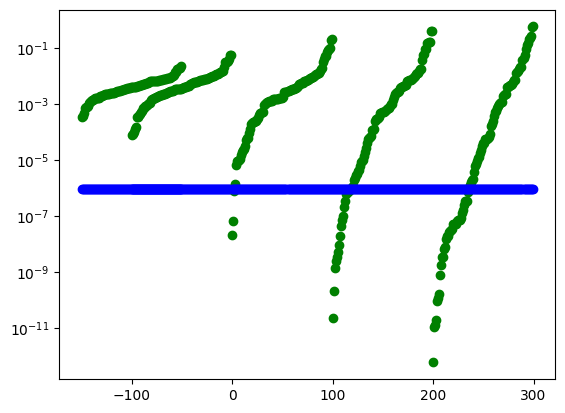

In [987]:
for j,tau in enumerate(tau_list):
    n_qubits = 10*tau
    print(n_qubits)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    #plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    #plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

3.0
4.0
6.0
8.0
10.0


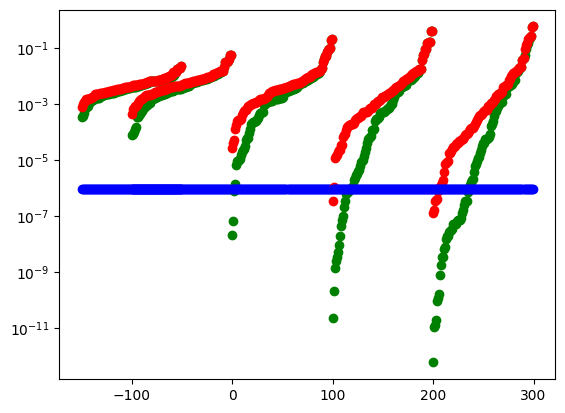

In [988]:
for j,tau in enumerate(tau_list):
    n_qubits = 10*tau
    print(n_qubits)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    #plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

3.0
4.0
6.0
8.0
10.0


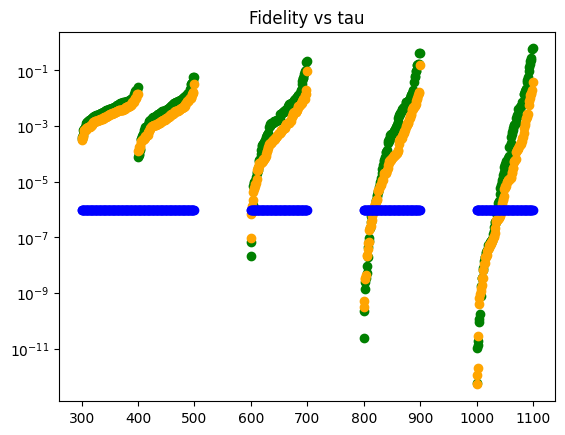

In [989]:
for j,tau in enumerate(tau_list):
    n_qubits = 10*tau
    print(n_qubits)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x + 100*10*tau, sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    plt.scatter(x + 100*10*tau , sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    #plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x + 100*10*tau, y4, label = 'random', color='blue')
    plt.yscale('log')
    plt.title('Fidelity vs tau')
    # plt.legend()


tau =  0.3 alpha =  0.01
-36.98820000000001 -33.79800552170073
-38.80699999999999 -37.41703760427643
-35.85279999999999 -33.37436994017552
-41.828600000000016 -37.56556412995207
-41.094100000000005 -37.46577246213517
-39.83129999999997 -35.30506691752139
-39.65400000000002 -35.92280131844568
-36.654800000000016 -35.91788257713665
-37.57340000000003 -33.84362543168681
-42.73890000000001 -40.475546825942814
-36.34900000000001 -33.78432563278948
-34.01970000000001 -31.28493465847021
-39.49150000000002 -36.0989485583524
-36.84799999999999 -34.13546870961841
-35.68050000000001 -32.93634280009414
-35.116200000000006 -32.650208309264784
-38.71230000000002 -34.90657559240964
-32.97609999999999 -31.335710688709394
-34.687900000000006 -33.37135580144934
-34.750200000000014 -33.171038246310836
-40.929599999999986 -36.91443756698843
-33.8075 -31.502794639538198
-39.296299999999995 -37.09060021898002
-39.5464 -36.50168359113786
-39.23970000000001 -36.00765288441981
-33.989499999999985 -32.11836234

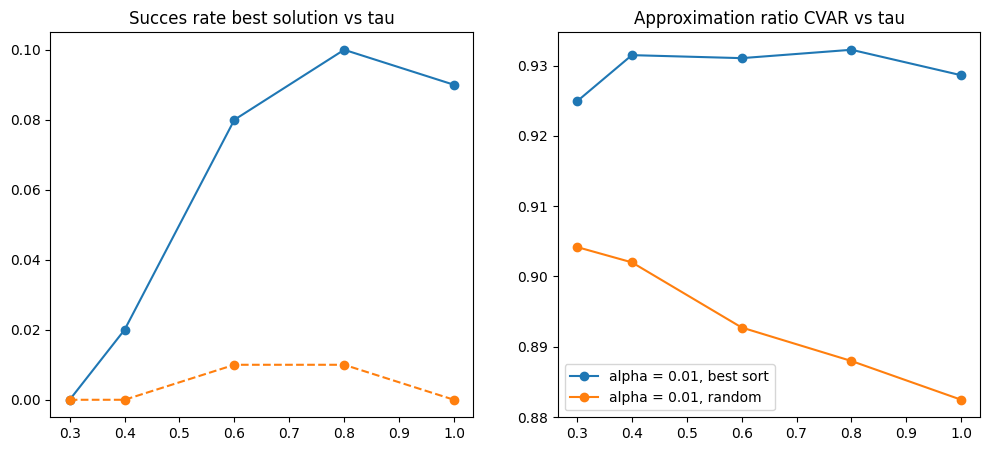

In [990]:
N=20
r_list = range(100)
tau_list = [0.3, 0.4, 0.6, 0.8, 1.0]
alpha_list = [0.01]

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
for alpha in alpha_list:
    sr_array = np.zeros((len(num_opt_list), len(tau_list)))
    ar_array = np.zeros(len(tau_list))
    rand_ar_array  = np.zeros(len(tau_list))
    for taui, tau in enumerate(tau_list):
        print("\ntau = ", tau, "alpha = ", alpha)
        # fidelities = np.sort(best_sorted_all_cvarfidelity[taui])[::-1]
        fidelities = best_sorted_all_cvarfidelity[taui]
        cvars = best_sorted_all_cvar[taui]

        rand_fidelity = solution_dict_all[taui]['old']['Random']
        rand_cvars = cvar_dict_all[taui]['old']['Random']

        best_energies = best_energy_all[taui]
        for r in r_list:
            if fidelities[r] > alpha*achange:
                sr_array[0, taui] += 1/len(r_list)
            if rand_fidelity[r] > alpha*achange:
                sr_array[1, taui] += 1/len(r_list)

            exp_opt = best_energies[r]
            ar_array[taui] += (cvars[r]/exp_opt) / len(r_list)

            rand_ar_array[taui] += (rand_cvars[r]/exp_opt) / len(r_list)
            print(exp_opt, cvars[r])

            

    print("sr_array = ", sr_array)
    ax1.plot(tau_list, sr_array[0], "o-", label=f"alpha = {alpha}, best sort")
    ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, random")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tau_list, ar_array, "o-", label=f"alpha = {alpha}, best sort")
    ax2.plot(tau_list, rand_ar_array, "o-", label=f"alpha = {alpha}, random")
    print("ar_array = ", ar_array)

    ax1.set_title('Succes rate best solution vs tau')
    ax2.set_title('Approximation ratio CVAR vs tau')
plt.legend()

In [991]:
best_sorted_all_cvarfidelity
best_sorted_all_cvar

[[-33.79800552170073,
  -37.41703760427643,
  -33.37436994017552,
  -37.56556412995207,
  -37.46577246213517,
  -35.30506691752139,
  -35.92280131844568,
  -35.91788257713665,
  -33.84362543168681,
  -40.475546825942814,
  -33.78432563278948,
  -31.28493465847021,
  -36.0989485583524,
  -34.13546870961841,
  -32.93634280009414,
  -32.650208309264784,
  -34.90657559240964,
  -31.335710688709394,
  -33.37135580144934,
  -33.171038246310836,
  -36.91443756698843,
  -31.502794639538198,
  -37.09060021898002,
  -36.50168359113786,
  -36.00765288441981,
  -32.118362345905005,
  -34.095930103114235,
  -36.70205587062998,
  -35.23542861435713,
  -39.28663773895375,
  -30.728201297316414,
  -34.21013107141429,
  -39.28575219133265,
  -29.235699281856025,
  -33.62505848545491,
  -32.17814632557792,
  -36.35651361178289,
  -33.965725313474955,
  -35.23099910349565,
  -38.317914482831306,
  -37.18121929322541,
  -31.311192019379668,
  -36.69288990690067,
  -37.06254109870088,
  -31.167224357451396

In [992]:
np.sort(solution_dict_all[0]['old']['Random'])[::-1]

array([0.01374351, 0.01353586, 0.01027517, 0.0098405 , 0.00966987,
       0.00888194, 0.00838147, 0.0074496 , 0.00716816, 0.00692223,
       0.00617463, 0.00577349, 0.00574348, 0.00538627, 0.00519401,
       0.00505039, 0.0050138 , 0.00486511, 0.00481902, 0.00481601,
       0.0048003 , 0.00458711, 0.00439645, 0.00417097, 0.0041012 ,
       0.00395754, 0.00380696, 0.00373855, 0.00368408, 0.00367343,
       0.00366473, 0.00365778, 0.00364681, 0.00363832, 0.00343774,
       0.00342735, 0.00340576, 0.00339652, 0.00318339, 0.00301923,
       0.00301793, 0.00297196, 0.0029568 , 0.00286527, 0.00281559,
       0.00277812, 0.00275664, 0.00272843, 0.00269435, 0.00259847,
       0.00254289, 0.00252993, 0.00243508, 0.00226476, 0.00224761,
       0.00209389, 0.00207736, 0.00207371, 0.00204516, 0.00199807,
       0.00191609, 0.00186628, 0.00178473, 0.00175886, 0.00172857,
       0.00170632, 0.00168767, 0.00166913, 0.0016633 , 0.00156502,
       0.00156338, 0.00150784, 0.0014889 , 0.00147879, 0.00147

In [993]:
np.sort(best_sorted_all_cvarfidelity[0])[::-1]

array([0.02389703, 0.01984066, 0.01919439, 0.01799287, 0.01775558,
       0.01410082, 0.01354908, 0.01103561, 0.01027517, 0.0098405 ,
       0.009055  , 0.00889785, 0.00888194, 0.00879292, 0.00835247,
       0.00806156, 0.00785344, 0.00769594, 0.00761816, 0.00727587,
       0.00718569, 0.00710326, 0.00700758, 0.00699346, 0.00699243,
       0.00692223, 0.00685869, 0.00679059, 0.00678868, 0.00667526,
       0.00655212, 0.00654291, 0.00595414, 0.00559574, 0.00555736,
       0.00553242, 0.00538627, 0.00538249, 0.00529188, 0.00485362,
       0.00482582, 0.0046609 , 0.00447495, 0.00443144, 0.00439474,
       0.00424282, 0.00422241, 0.00410886, 0.0041012 , 0.00404449,
       0.00400191, 0.00387307, 0.00380792, 0.00365598, 0.00365332,
       0.00360786, 0.00351774, 0.0033835 , 0.00330126, 0.00318339,
       0.00307595, 0.00304689, 0.00293105, 0.00287015, 0.00284838,
       0.0027715 , 0.00274343, 0.00258864, 0.00256581, 0.00251511,
       0.00244049, 0.00243787, 0.00235917, 0.00235284, 0.00233

In [994]:
np.sort(best_sorted_all_cvar[0])

array([-41.20946285, -40.88222653, -40.47554683, -40.43363491,
       -39.38737539, -39.28663774, -39.28575219, -38.43102332,
       -38.4001018 , -38.37901206, -38.31791448, -37.92751272,
       -37.56556413, -37.46577246, -37.4170376 , -37.18121929,
       -37.09060022, -37.0625411 , -37.02963231, -36.96688631,
       -36.91443757, -36.90387796, -36.74343778, -36.72041984,
       -36.70205587, -36.69288991, -36.61453681, -36.50168359,
       -36.35651361, -36.09894856, -36.00765288, -35.96550666,
       -35.92280132, -35.91788258, -35.87412405, -35.81669564,
       -35.80137434, -35.45322094, -35.39198985, -35.30506692,
       -35.23542861, -35.2309991 , -35.22820504, -35.10884832,
       -34.90657559, -34.71941059, -34.48927149, -34.21013107,
       -34.13546871, -34.13347734, -34.0959301 , -34.02293145,
       -33.98867686, -33.96572531, -33.9044676 , -33.84362543,
       -33.79800552, -33.78432563, -33.77173688, -33.62505849,
       -33.534639  , -33.46911244, -33.46204151, -33.37